# Exploratory Data Analysis (EDA)

This notebook will include:

1. Loading cleaned datasets
2. Aggregate renewable generation
3. Merging with price data
4. Adding useful time features
5. Generating EDA visuals and statistics

#### 1: Imports & File Paths

In [5]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Plot style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# File paths
price_path = "data/cleaned/price_demand_qld_2023_2024.csv"
renewable_path = "data/cleaned/renewable_generation_qld_2023_2024.csv"

#### 2: Load the Datasets from 'cleaned' folder

In [7]:
# Load cleaned QLD price + demand data
df_price = pd.read_csv(price_path, parse_dates=["SETTLEMENTDATE"])

# Load renewable generation (SCADA) data
df_renew = pd.read_csv(renewable_path, parse_dates=["SETTLEMENTDATE"])

# Confirm shapes
print("Price data:", df_price.shape)
print("Renewable generation data:", df_renew.shape)

Price data: (166494, 58)
Renewable generation data: (8107423, 5)


#### 3: Display Column Names from Both Datasets

In [9]:
# Show all column names from price data
print(" PRICE DATA columns:")
print(df_price.columns.tolist())

# Show all column names from renewable generation data
print("\n RENEWABLE GENERATION DATA columns:")
print(df_renew.columns.tolist())

 PRICE DATA columns:
['I', 'DISPATCH', 'PRICE', '4', 'SETTLEMENTDATE', 'RUNNO', 'REGIONID', 'DISPATCHINTERVAL', 'INTERVENTION', 'RRP', 'EEP', 'ROP', 'APCFLAG', 'MARKETSUSPENDEDFLAG', 'LASTCHANGED', 'RAISE6SECRRP', 'RAISE6SECROP', 'RAISE6SECAPCFLAG', 'RAISE60SECRRP', 'RAISE60SECROP', 'RAISE60SECAPCFLAG', 'RAISE5MINRRP', 'RAISE5MINROP', 'RAISE5MINAPCFLAG', 'RAISEREGRRP', 'RAISEREGROP', 'RAISEREGAPCFLAG', 'LOWER6SECRRP', 'LOWER6SECROP', 'LOWER6SECAPCFLAG', 'LOWER60SECRRP', 'LOWER60SECROP', 'LOWER60SECAPCFLAG', 'LOWER5MINRRP', 'LOWER5MINROP', 'LOWER5MINAPCFLAG', 'LOWERREGRRP', 'LOWERREGROP', 'LOWERREGAPCFLAG', 'PRICE_STATUS', 'PRE_AP_ENERGY_PRICE', 'PRE_AP_RAISE6_PRICE', 'PRE_AP_RAISE60_PRICE', 'PRE_AP_RAISE5MIN_PRICE', 'PRE_AP_RAISEREG_PRICE', 'PRE_AP_LOWER6_PRICE', 'PRE_AP_LOWER60_PRICE', 'PRE_AP_LOWER5MIN_PRICE', 'PRE_AP_LOWERREG_PRICE', 'CUMUL_PRE_AP_ENERGY_PRICE', 'CUMUL_PRE_AP_RAISE6_PRICE', 'CUMUL_PRE_AP_RAISE60_PRICE', 'CUMUL_PRE_AP_RAISE5MIN_PRICE', 'CUMUL_PRE_AP_RAISEREG_PRICE', 

#### 4: Drop Columns & Remove Incomplete August 2024 Data
To ensure data consistency and prevent misleading trends in the analysis, we excluded all records from August 2024 onward. While the renewable_generation_qld_2023_2024.csv file contained partial data for August 2024, the corresponding price_demand_qld_2023_2024.csv had only a single timestamp (00:00:00 on August 1st), which could lead to mismatches, incorrect aggregations, and misleading visualizations. By removing these incomplete entries from both datasets early in the preprocessing stage—immediately after dropping unnecessary columns—we ensured that all subsequent analysis, including monthly trend plots and forecasting models, were based on complete and reliable data only.

In [11]:
# Step 4: Drop unnecessary columns
df_price = df_price[["SETTLEMENTDATE", "RRP"]].copy()
df_renew = df_renew[["SETTLEMENTDATE", "SCADAVALUE", "Fuel Source - Primary"]].copy()

# Step 4.1: Remove partial data from August 2024
cutoff_date = "2024-08-01"
df_price = df_price[df_price["SETTLEMENTDATE"] < cutoff_date].copy()
df_renew = df_renew[df_renew["SETTLEMENTDATE"] < cutoff_date].copy()

# Confirm date ranges
print("Max timestamp in price data:", df_price["SETTLEMENTDATE"].max())
print("Max timestamp in renewable data:", df_renew["SETTLEMENTDATE"].max())

Max timestamp in price data: 2024-07-31 23:55:00
Max timestamp in renewable data: 2024-07-31 23:55:00


#### 5: Aggregate Renewable Output by Timestamp
Now sum SCADAVALUE across all renewable DUIDs for each SETTLEMENTDATE, giving us the total renewable generation in MW per 5-minute interval.

In [13]:
# Aggregate renewable generation (MW) by timestamp
df_renew_agg = df_renew.groupby("SETTLEMENTDATE", as_index=False)["SCADAVALUE"].sum()

# Rename column for clarity
df_renew_agg.rename(columns={"SCADAVALUE": "Renewable_MW"}, inplace=True)

# Preview
print("Aggregated renewable generation:")
df_renew_agg.head()

Aggregated renewable generation:


,SETTLEMENTDATE,Renewable_MW
0,2023-01-01 00:05:00,633.11051
1,2023-01-01 00:10:00,676.97985
2,2023-01-01 00:15:00,639.00461
3,2023-01-01 00:20:00,632.88514
4,2023-01-01 00:25:00,622.08665


#### 6: Merge Price and Renewable Datasets
By combining df_price and df_renew_agg on the common timestamp column SETTLEMENTDATE, this will allow you to:
1. Plot RRP vs Renewable Generation
2. Run correlation checks
3. Build joint time-series visualizations

In [15]:
# Merge price and renewable generation data on SETTLEMENTDATE
df_merged = pd.merge(df_price, df_renew_agg, on="SETTLEMENTDATE", how="inner")

# Preview merged result
print(" Merged dataset shape:", df_merged.shape)
df_merged.head()

 Merged dataset shape: (166493, 3)


,SETTLEMENTDATE,RRP,Renewable_MW
0,2023-01-01 00:05:00,139.73017,633.11051
1,2023-01-01 00:10:00,136.00000,676.97985
2,2023-01-01 00:15:00,121.79643,639.00461
3,2023-01-01 00:20:00,121.61086,632.88514
4,2023-01-01 00:25:00,120.67186,622.08665


#### 7: Add Time-Based Features
Let’s extract:
1. Hour of day
2. Day of week
3. Month

In [17]:
# Convert timestamp to datetime (if not already)
df_merged["SETTLEMENTDATE"] = pd.to_datetime(df_merged["SETTLEMENTDATE"])

# Add time-based features
df_merged["Hour"] = df_merged["SETTLEMENTDATE"].dt.hour
df_merged["DayOfWeek"] = df_merged["SETTLEMENTDATE"].dt.day_name()
df_merged["Month"] = df_merged["SETTLEMENTDATE"].dt.month_name()
df_merged["Date"] = df_merged["SETTLEMENTDATE"].dt.date

# Preview
df_merged.head(500)

,SETTLEMENTDATE,RRP,Renewable_MW,Hour,DayOfWeek,Month,Date
0,2023-01-01 00:05:00,139.73017,633.110510,0,Sunday,January,2023-01-01
1,2023-01-01 00:10:00,136.00000,676.979850,0,Sunday,January,2023-01-01
2,2023-01-01 00:15:00,121.79643,639.004610,0,Sunday,January,2023-01-01
3,2023-01-01 00:20:00,121.61086,632.885140,0,Sunday,January,2023-01-01
4,2023-01-01 00:25:00,120.67186,622.086650,0,Sunday,January,2023-01-01
...,...,...,...,...,...,...,...
495,2023-01-02 17:20:00,106.52826,1661.584920,17,Monday,January,2023-01-02
496,2023-01-02 17:25:00,133.73670,1546.086330,17,Monday,January,2023-01-02
497,2023-01-02 17:30:00,145.01000,1487.055322,17,Monday,January,2023-01-02
498,2023-01-02 17:35:00,109.00000,1390.887100,17,Monday,January,2023-01-02


#### 8: Exploratory Visualizations
This includes:
1. Line plot of RRP over time
2. Line plot of Renewable_MW over time
3. Overlay plot to compare both trends
(Optional) We'll Resample to daily averages for clearer patterns

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


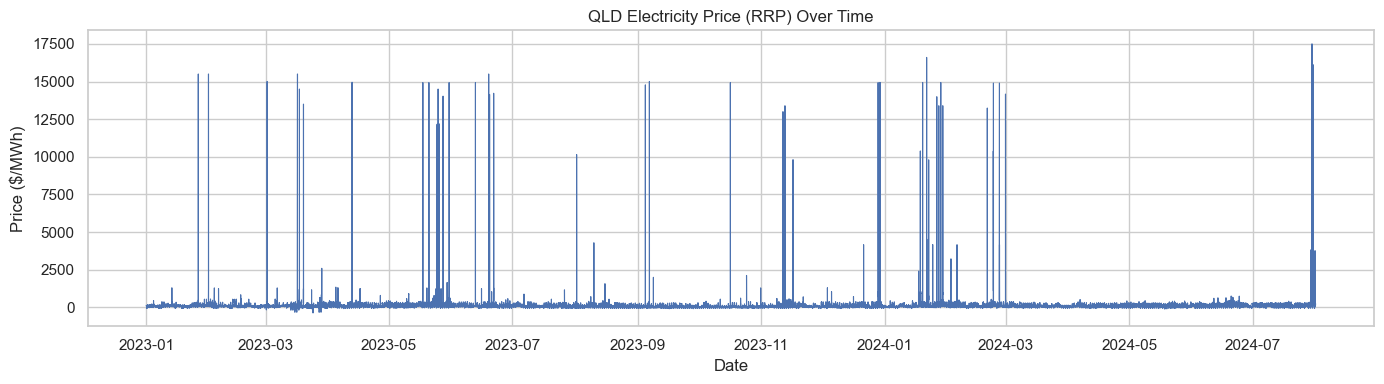

In [19]:
# Plot and save RRP over time
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_merged, x="SETTLEMENTDATE", y="RRP", linewidth=0.8)
plt.title("QLD Electricity Price (RRP) Over Time")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
plt.tight_layout()

# Save plot to file
output_dir = "figures"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(f"{output_dir}/rrp_over_time.png", dpi=300)

# Show inline
plt.show()

##### Cleaner RRP Plot (Daily Avg with Capped Y-axis)

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


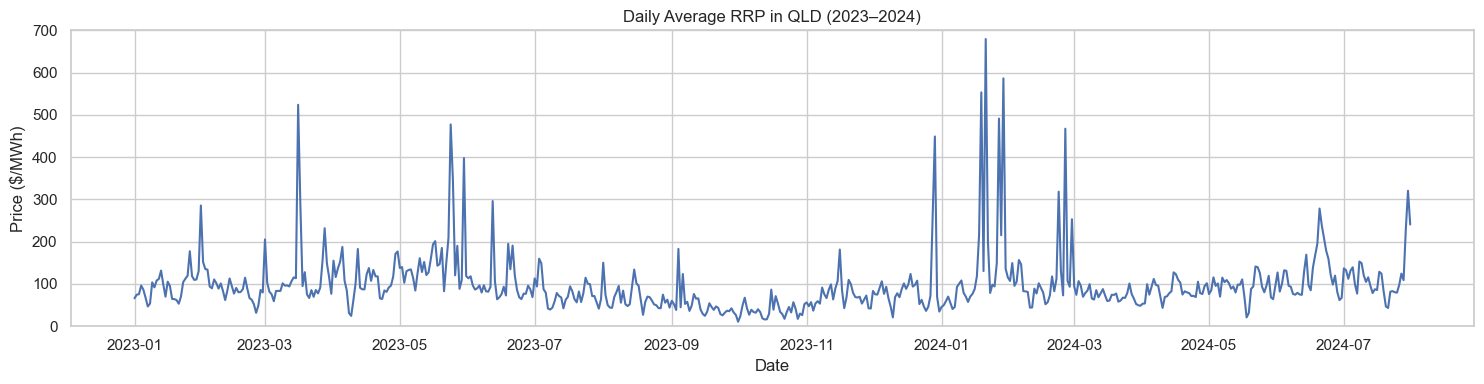

In [21]:
# Resample RRP to daily average
df_daily_rrp = df_merged.set_index("SETTLEMENTDATE").resample("D")["RRP"].mean().reset_index()

# Plot daily RRP with capped Y-axis
plt.figure(figsize=(15, 4))
sns.lineplot(data=df_daily_rrp, x="SETTLEMENTDATE", y="RRP")
plt.title("Daily Average RRP in QLD (2023–2024)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Date")
plt.ylim(0, 700)  # Cap Y-axis to avoid spike distortion
plt.tight_layout()

# Save the plot
plt.savefig("figures/rrp_daily_avg_limited.png", dpi=300)
plt.show()

#### 9: Daily Renewable Generation Plot
Here we will:
1. Resample Renewable_MW to daily totals or averages
2. Plot the trend over time
3. Save the plot as a high-quality PNG

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


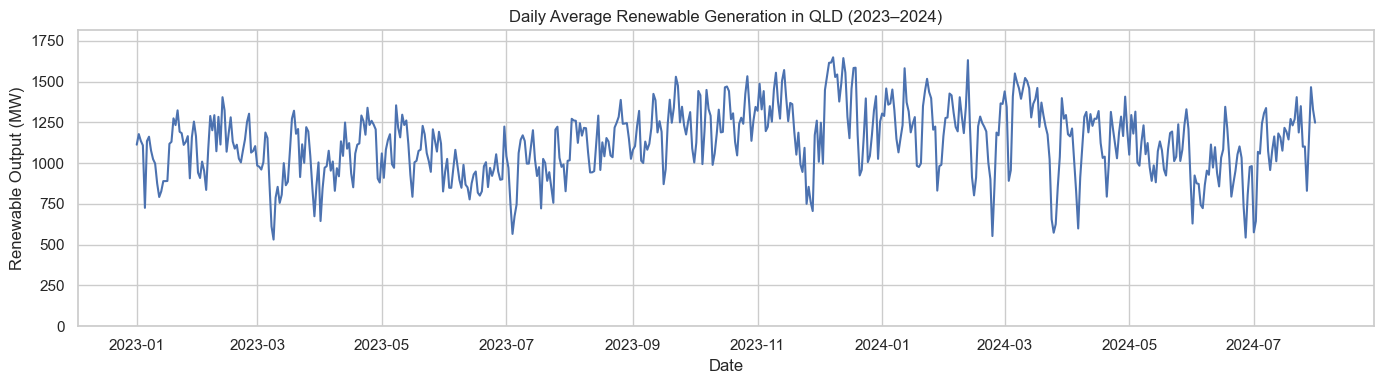

In [23]:
# Resample to daily average renewable generation
df_daily_renew = df_merged.set_index("SETTLEMENTDATE").resample("D")["Renewable_MW"].mean().reset_index()

# Plot and save the figure
plt.figure(figsize=(14, 4))
sns.lineplot(data=df_daily_renew, x="SETTLEMENTDATE", y="Renewable_MW")
plt.title("Daily Average Renewable Generation in QLD (2023–2024)")
plt.ylabel("Renewable Output (MW)")
plt.xlabel("Date")
plt.ylim(0, df_daily_renew["Renewable_MW"].max() * 1.1)  # Add 10% headroom
plt.tight_layout()

# Save the figure
plt.savefig("figures/renewable_daily_avg.png", dpi=300)
plt.show()

#### 10. Correlation Between RRP and Renewable_MW
- A scatter plot of Renewable_MW vs RRP
- A regression line (trend line)
- Pearson correlation coefficient

 Pearson Correlation between RRP and Renewable_MW: -0.125


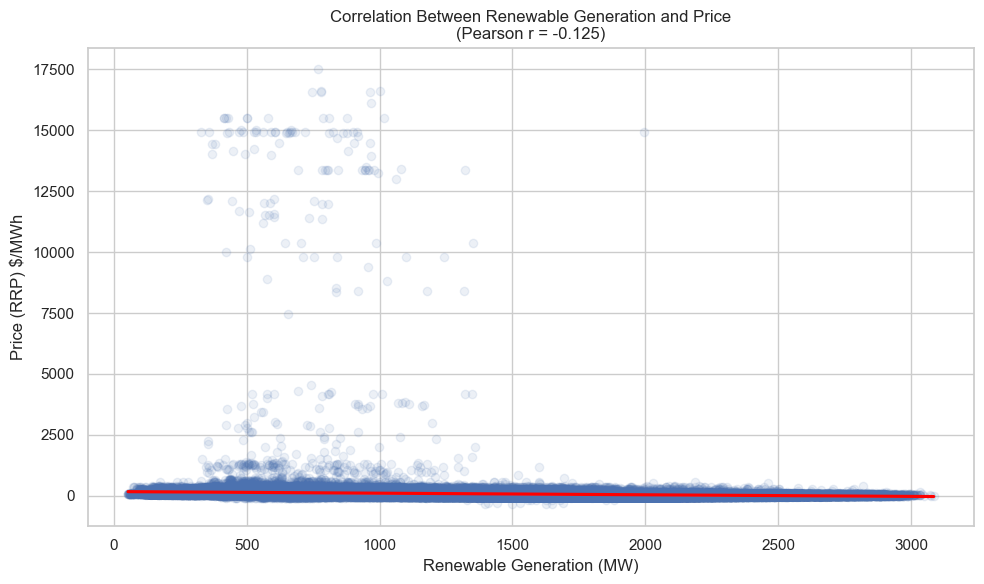

In [25]:
# Compute Pearson correlation
correlation = df_merged["RRP"].corr(df_merged["Renewable_MW"])
print(f" Pearson Correlation between RRP and Renewable_MW: {correlation:.3f}")

# Scatter plot with regression line
plt.figure(figsize=(10, 6))
sns.regplot(data=df_merged, x="Renewable_MW", y="RRP", scatter_kws={"alpha": 0.1}, line_kws={"color": "red"})
plt.title(f"Correlation Between Renewable Generation and Price\n(Pearson r = {correlation:.3f})")
plt.xlabel("Renewable Generation (MW)")
plt.ylabel("Price (RRP) $/MWh")
plt.tight_layout()

# Save the figure
plt.savefig("figures/rrp_vs_renewable_correlation.png", dpi=300)
plt.show()

<b> Correlation Result: r = -0.125 </b> <br>
This means:
- There is a slight negative correlation between renewable generation and spot prices.
- As renewable output increases, prices tend to decrease slightly — but the effect is weak.
- Most values are clustered at lower price levels, but price spikes can still occur even with moderate renewable generation — likely due to:
-- Sudden demand surges
-- Generator outages
-- Market intervention events



### Explore Seasonal Patterns in Price and Renewables
We’ll now generate:
- Average RRP by Month – See if prices tend to be higher in summer/winter.
- Average Renewable Output by Month – Check seasonal solar/wind/hydro variations.

#### 11.1: Average RRP by Month

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


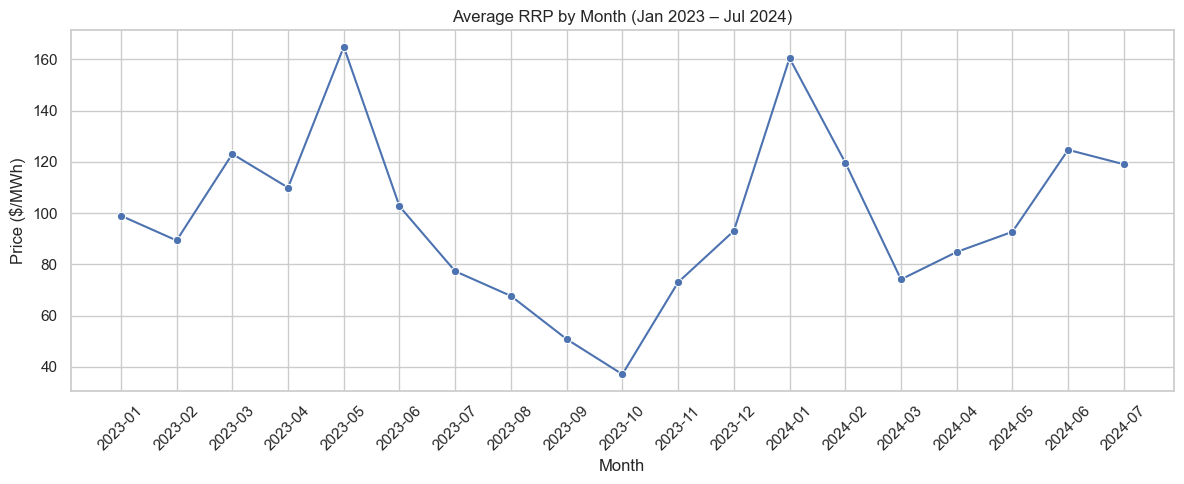

In [29]:
# Create 'Year-Month' column for grouping
df_merged["YearMonth"] = df_merged["SETTLEMENTDATE"].dt.to_period("M").astype(str)

# Monthly average RRP using Year-Month
monthly_rrp_full = df_merged.groupby("YearMonth")["RRP"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_rrp_full, x="YearMonth", y="RRP", marker="o")
plt.title("Average RRP by Month (Jan 2023 – Jul 2024)")
plt.ylabel("Price ($/MWh)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig("figures/avg_rrp_by_year_month.png", dpi=300)
plt.show()

<b>Note:</b> Same unit ($/MWh), but different aggregation levels tell different stories. We use raw plots to explore volatility, and monthly plots to understand seasonal patterns.

#### 11.2: Plot – Average Renewable Generation by Month
This will help identify:
- Seasonal trends (e.g. stronger solar in summer?)
- Drops or surges that may influence RRP

C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


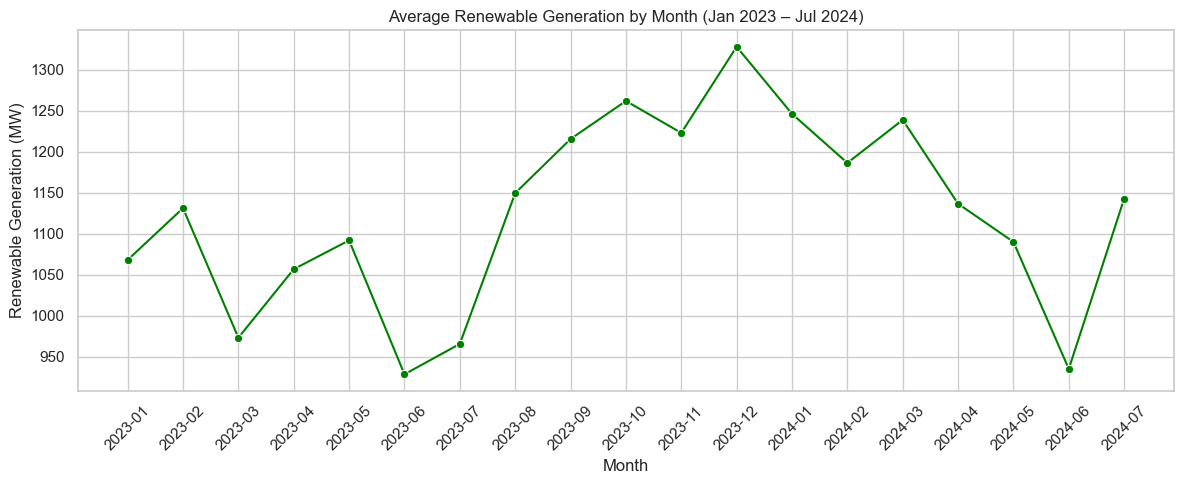

In [32]:
# Monthly average Renewable_MW using Year-Month
monthly_renew = df_merged.groupby("YearMonth")["Renewable_MW"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=monthly_renew, x="YearMonth", y="Renewable_MW", marker="o", color="green")
plt.title("Average Renewable Generation by Month (Jan 2023 – Jul 2024)")
plt.ylabel("Renewable Generation (MW)")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plt.savefig("figures/avg_renewable_by_year_month.png", dpi=300)
plt.show()

#### 12. Save DataFrames for Modeling

In [34]:
# 1. Save the full 5-min merged dataset for LSTM and future EDA
df_merged.to_csv("data/cleaned/merged_rrp_renewables_qld_5min.csv", index=False)
print("Saved: merged_rrp_renewables_qld_5min.csv")

# 2. Save daily RRP for SARIMA
df_daily_rrp = df_merged.set_index("SETTLEMENTDATE").resample("D")["RRP"].mean().reset_index()
df_daily_rrp.to_csv("data/cleaned/rrp_qld_daily.csv", index=False)
print("Saved: rrp_qld_daily.csv")

# 3. Save daily RRP + Renewables for SARIMAX
df_daily_merged = df_merged.set_index("SETTLEMENTDATE").resample("D")[["RRP", "Renewable_MW"]].mean().reset_index()
df_daily_merged.to_csv("data/cleaned/rrp_renewables_qld_daily.csv", index=False)
print("Saved: rrp_renewables_qld_daily.csv")


Saved: merged_rrp_renewables_qld_5min.csv
Saved: rrp_qld_daily.csv
Saved: rrp_renewables_qld_daily.csv


In [35]:
# 4 Extract hourly renewable generation 
# To simulate and compare how peak vs off-peak renewable generation impacts electricity prices in Queensland using SARIMAX.
# Load the full dataset
df = pd.read_csv("data/cleaned/renewable_generation_qld_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# Filter only for Queensland renewables (assuming all are QLD — or filter by DUID if needed)
# If we want only solar, wind, hydro
renewables = ["Solar", "Wind", "Hydro"]
df = df[df["Fuel Source - Primary"].isin(renewables)]

# Set datetime index and resample to hourly (sum SCADAVALUE across all units)
df.set_index("SETTLEMENTDATE", inplace=True)
df_hourly = df["SCADAVALUE"].resample("H").sum().reset_index()
df_hourly.rename(columns={"SCADAVALUE": "Renewable_MW"}, inplace=True)

C:\Users\enggv\AppData\Local\Temp\ipykernel_9380\1403889542.py:13: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["SCADAVALUE"].resample("H").sum().reset_index()


In [36]:
# Save to a smaller CSV for upload
df_hourly.to_csv("data/cleaned/renewable_generation_hourly_qld.csv", index=False)

print("Saved hourly renewable generation data to 'renewable_generation_hourly_qld.csv'")

Saved hourly renewable generation data to 'renewable_generation_hourly_qld.csv'


In [37]:
# 5 Extract Regional Reference Price to hourly

In [38]:
# Load the 5-minute price data
df_price = pd.read_csv("data/cleaned/price_demand_qld_2023_2024.csv", parse_dates=["SETTLEMENTDATE"])

# Keep only the relevant columns
df_price = df_price[["SETTLEMENTDATE", "RRP"]]

# Round down to the hour
df_price["Hour"] = df_price["SETTLEMENTDATE"].dt.floor("H")

# Group by hour and calculate the average RRP
df_rrp_hourly = df_price.groupby("Hour").mean().reset_index()
df_rrp_hourly.rename(columns={"Hour": "Datetime", "RRP": "Avg_RRP"}, inplace=True)

# Save the result
df_rrp_hourly.to_csv("data/cleaned/rrp_hourly.csv", index=False)

print("Hourly average RRP saved to 'data/cleaned/rrp_hourly.csv'")

Hourly average RRP saved to 'data/cleaned/rrp_hourly.csv'


C:\Users\enggv\AppData\Local\Temp\ipykernel_9380\322890013.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_price["Hour"] = df_price["SETTLEMENTDATE"].dt.floor("H")
